# Research Notebook
## Dana Luke Gheshlaghi
## Date: February 27th, 2025

# 1: Experience
## Describe at least one research activity you worked on this week.

- Watched the last three lectures of Professor Tulin's videos
- Finished writing my code for the decay interactions and have implemented it into a class within the SPH package to be used for future simulations

## Motivation:

We're still learning more about the SPH package that will help simulate the interacting dark matter halos by using spherical symmetry. Right now the code is not ready to be used to make the simulations yet. The simulation team, which is my team, first need to finish writing the code for the decay interactions as well as the up-scattering + decay equations. The quantum team, is using the Schrödinger equation to solve for the inelastic cross section $\sigma_{in}$ so that we can apply it to the code we are writing and the euler equations.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

The bulk of what I've done has been on code, attempting to write the decay interaction equations from ref. [3] which are:
- $ \frac{d m^*_i}{dt} = - \Gamma_2 m_i^* $ (1)
- $ \frac{dm_i}{dt} = \Gamma_2 \sum_j T_{ij} m_j^* $ (2)
- $ \frac{d v_i}{dt} = \Gamma_2 \sum_j T_{ij} \frac{\rho^*_j}{\rho_i} \left( v_j^* - v_i \right) + ... $ (3)
- $ \frac{d e_i}{dt} = \Gamma_2 \sum_j T_{ij}  \frac{\rho_j^*}{\rho_i} \Big( \tfrac{1}{2} \delta^2 + \tfrac{1}{2} (v_i - v_j^*)^2 + (e_j^* - e_i) \Big) + ... $ (4)

```
def ground_state_decay(ground_state_shells,excited_state_shells):

    e1, v1, r1, m1, h1, rho1, W1 = ground_state_shells.e, ground_state_shells.v, ground_state_shells.r, ground_state_shells.m, ground_state_shells.h, ground_state_shells.density, ground_state_shells.kernels.W
    e2, v2, r2, m2, h2, rho2, W2 = excited_state_shells.e, excited_state_shells.v, excited_state_shells.r, excited_state_shells.m, excited_state_shells.h, excited_state_shells.density, excited_state_shells.kernels.W

    T2, delta, num = 1, 0.01, ground_state_shells.num

    # The stress tensor equation (71)
    Wij2 = np.array([[W1(r1[i], r2[j], h1[i]) for j in range(num)] for i in range(num)])
    den = np.sum(Wij2, axis=0)
    Tij = np.array([[((Wij2[i][j]) / den[i]) for j in range(num)] for i in range(num)])

    # Matrix multiplication to get equation (74) dm1_dt
    multi1 = np.array([np.array(Tij[j] * m2[j]) for j in range(num)])
    dm_dt = np.sum(multi1, axis=1)

    # Equation (75) dv1_dt
    multi2 = np.array([[Tij[i][j] * (rho2[j] / rho1[i]) * (v2[j] - v1[i]) for j in range(num)] for i in range(num)])
    dv_dt = np.sum(multi2, axis=1)

    # Equation (76) de1_dt
    multi3 = np.array([[Tij[i][j] * (rho2[j] / rho1[i]) for j in range(num)] for i in range(num)])
    multi4 = np.array(
        [[0.5 * delta ** 2 + 0.5 * (v1[i] - v2[j]) ** 2 + (e2[j] - e1[i]) for j in range(num)] for i in range(num)])

    de_dt = np.sum(multi3 * multi4, axis=1)

    return dm_dt, dv_dt, de_dt

def excited_state_decay(ground_state_shells,excited_state_shells):

    T2, m2 = 1, excited_state_shells.m

    dm_dt = -m2

    return dm_dt
```

This block of code shows the decay interation equations pasted into a function inside a class the professor created to be used for simulations of dark matter halo. Equation (1) can be seen in the 'excited_state_decay' function, it is the change in mass of the excited state. The other following equations are inside the 'ground_state_decay' function, (2) calculates the change in mass of the ground state, (3) is the change in velocity, and (4) is the change in internal energy.

```
rho_s, rs = 2.5e9, 0.01
rho1 = SPH.analytic.density('NFW',rho_s*0.1,rs)
rho2 = SPH.analytic.density('NFW',rho_s*0.9,rs)

# Define rmin and rmax for shells
rmin, rmax = 0.001*rs, 100*rs

halo = SPH.create.ensemble([rho1,rho2], rmin, rmax)
ground_shells, excited_shells = halo.zoo

dm1_dt, dv_dt, de_dt = decay.ground_state_decay(ground_shells, excited_shells)
dm2_dt = decay.excited_state_decay(ground_shells, excited_shells)

# Ground state interactions
interaction1 = {'type':'decay_ground_state', 'params':[1]}

# Excited state interactions
interaction2 = {'type':'decay_excited_state', 'params':[1]}

# Create ensemble
halo = SPH.create.ensemble([rho1,rho2], rmin, rmax, interaction=[interaction1, interaction2])

# Time evolution
t_steps = np.linspace(0,1,num=100)
halo.evolve(t_steps,filename='decay_test',savemode='w', verbose = True,attrs=[['r','v','e','h','m'],['r','v','e','h','m']])
```

I was able to extend my work by following his tutorial on using the SPH code and write up my own simulation. I set the parameters of the density of the halo and the size as well as amount of shells I want to be studied within the halo. I called my decay function and filled it with data using the halo.zoo, as well as making a time evolution spanning one giga year to see what happened to the ground state and excited state dark matter after decay interaction.



# 3: So what? (What does it mean?)
## Describe your results

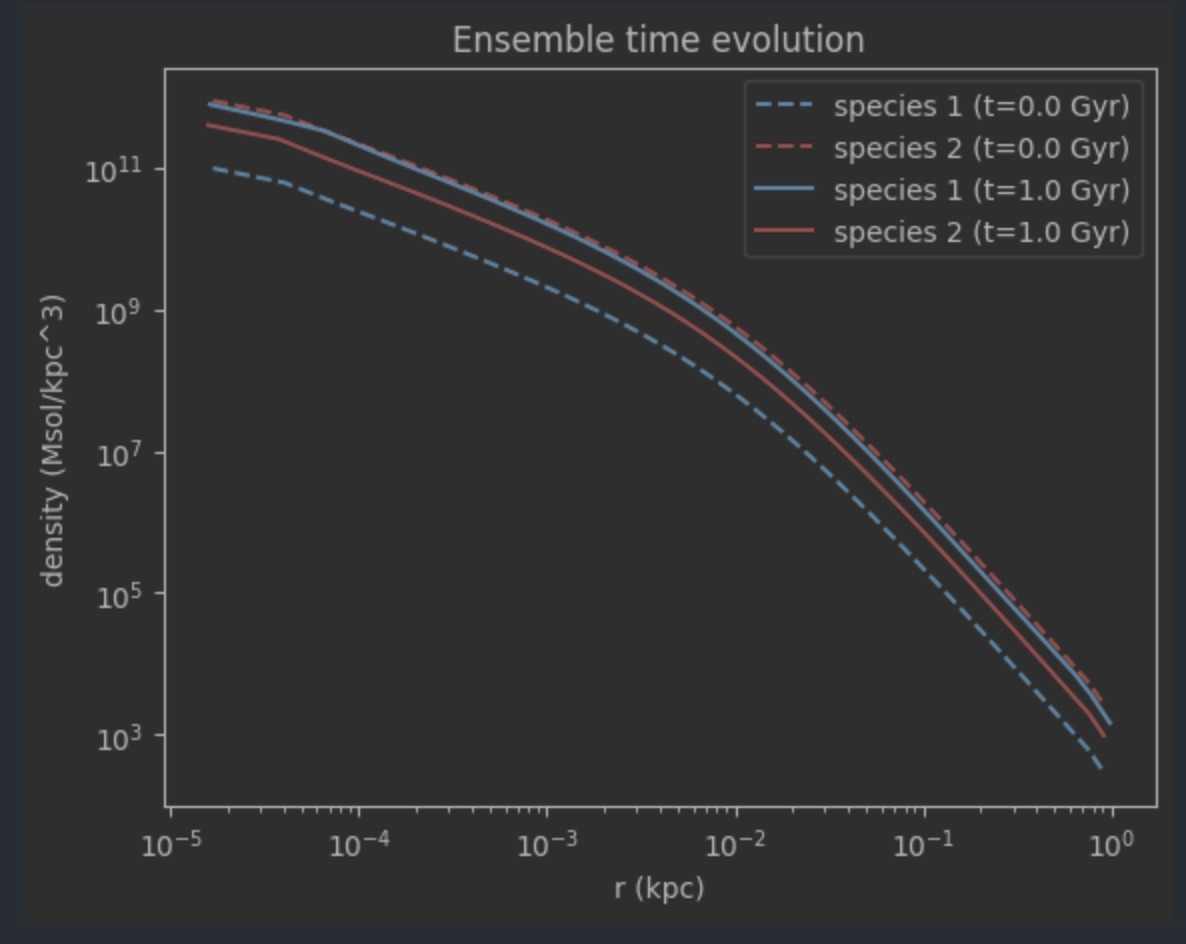

I've created a time evolved ensemble simulating the interactions over a set time. An ensemble is defined as, 'an object representing a halo with multiple different species, with each different species having its own shells object' [4]. The time evolved ensemble accounts for gravity, so the gravitational force a species exerts is considered in the calculation of their interaction between other species in the ensemble. Here we see a plot of the density vs time over 1 giga year, mirroring the navarro frenk white profile. The blue indicates the ground state and the red is the excited state, over time excited state has become uniformly less dense throughout the whole shell while the ground state has become uniformly more dense.

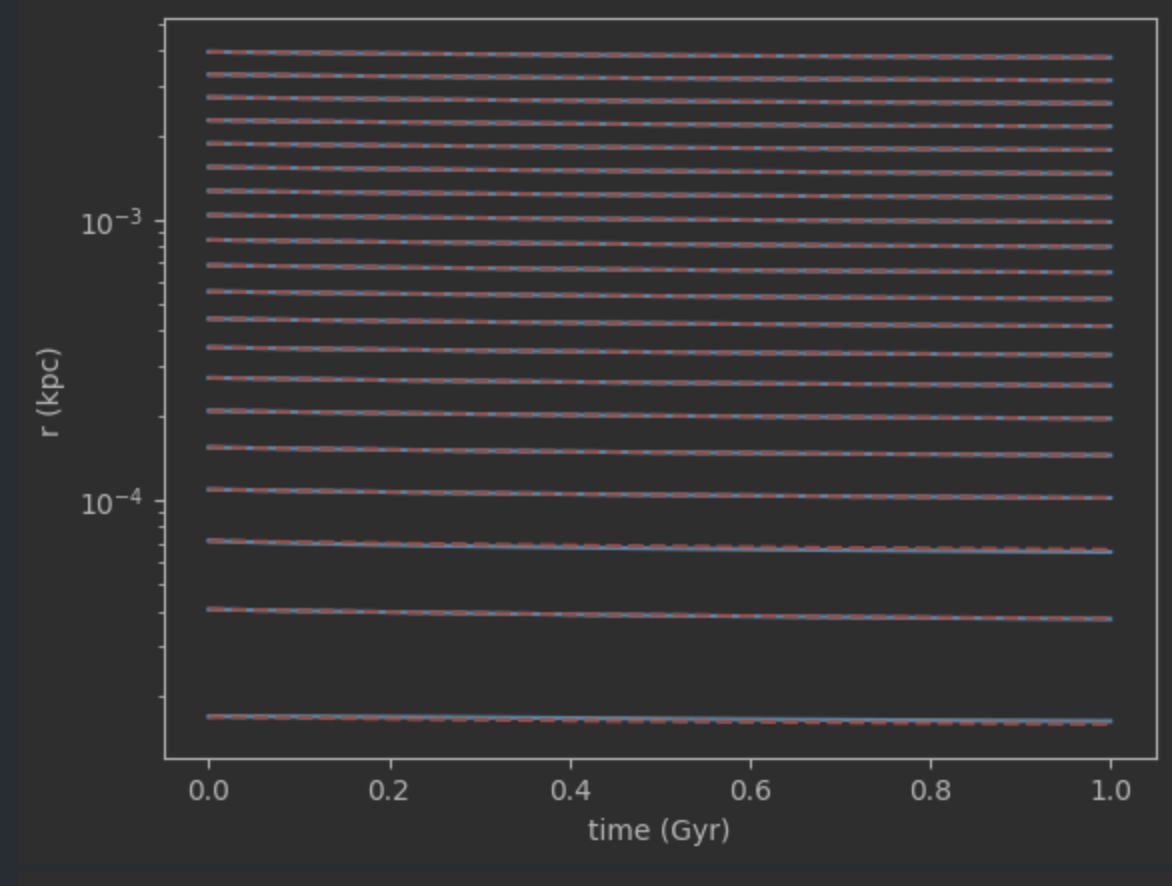

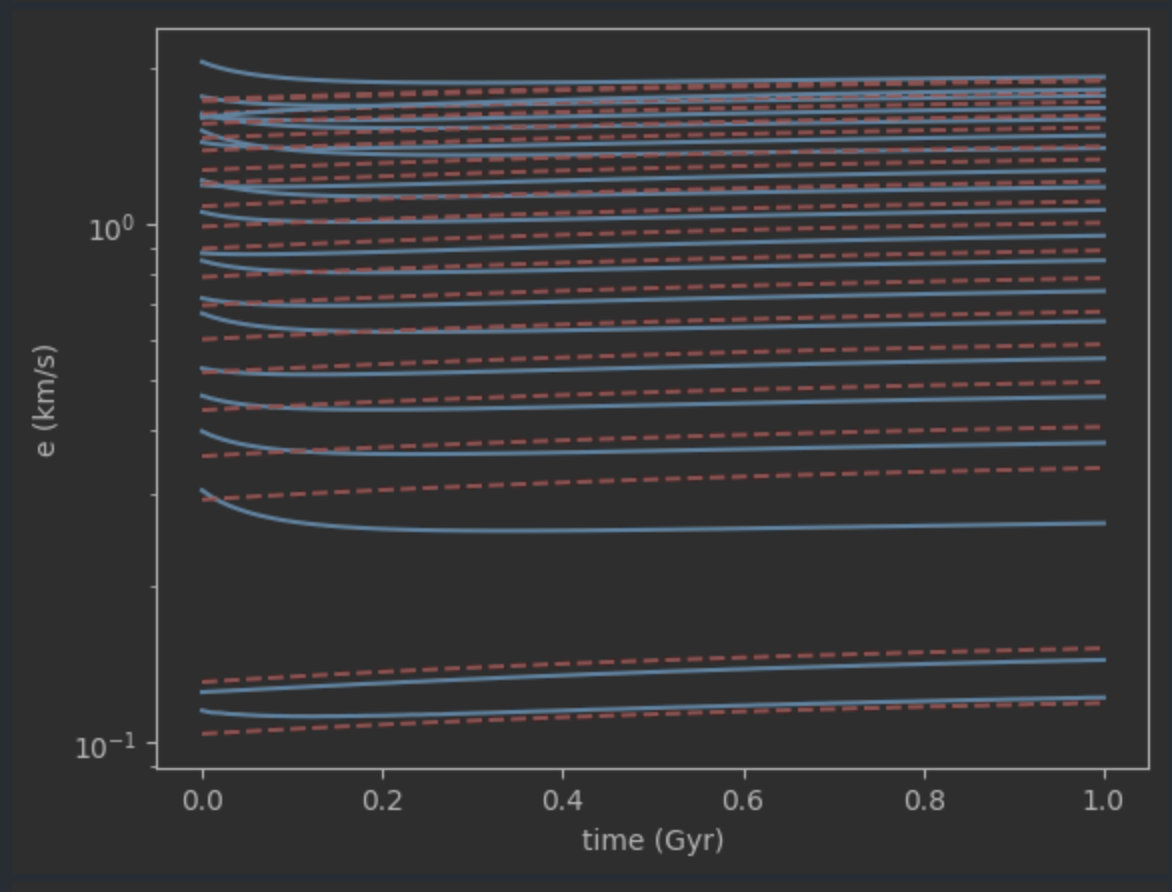

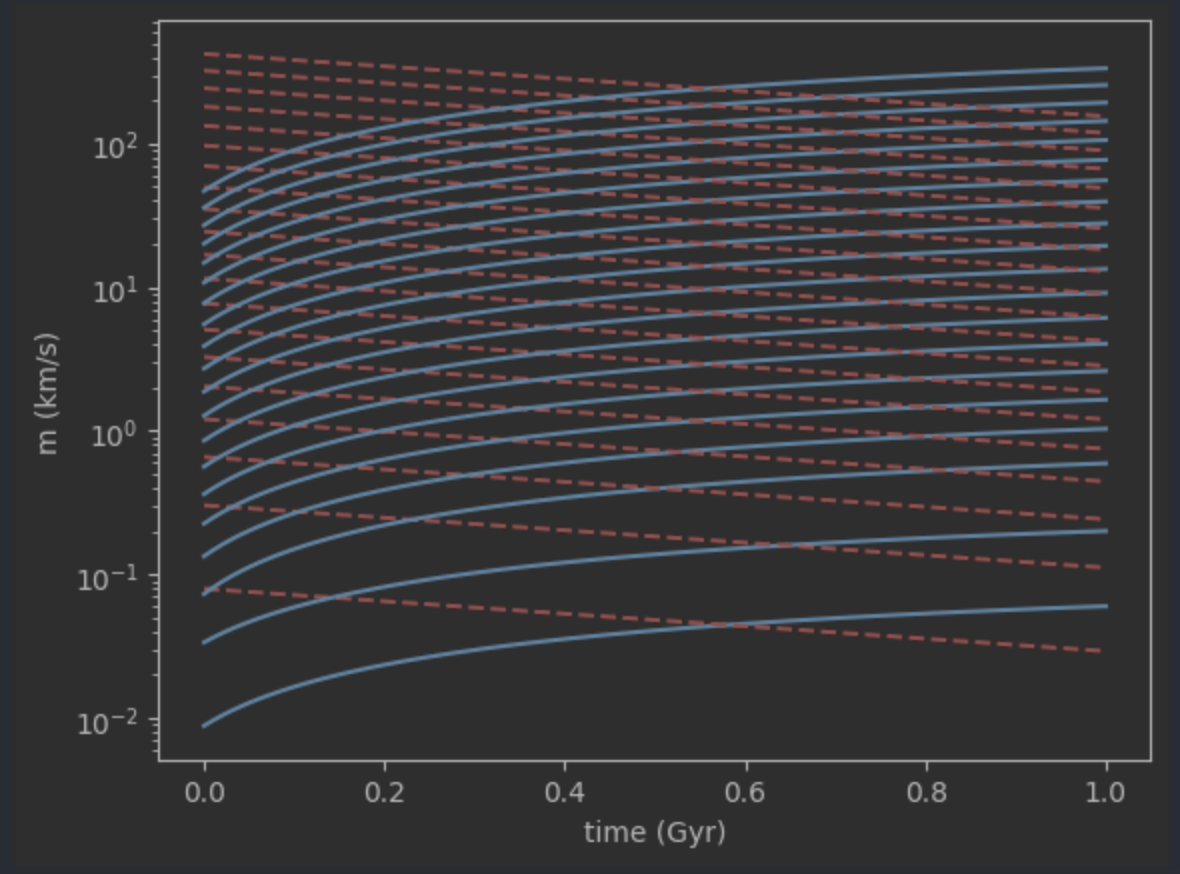


The following plots are the radius, internal energy, and mass vs time spanning a giga year, using the evolve.py file inside the SPH code, it is able to use my decay equations to give me not only those 3 attributes, but it also calculates the velocity and smoothing length. Unfortunately, I am having trouble understanding the plots I have made and even with a test to see if the data is sufficient, I'm not able to explain the physics behind the radius vs time or internal energy vs time plot. The mass plot though does agree with the density vs time as we see the ground state mass increases while the excited state mass declines over time.

# 4. Now what? (What's next?)
## Plan for the next week
- Professor Tulin has made some updates on the paper he's writing regarding the decay/up-scattering equations that will be included into the SPH code, so I should catch up on reading what has been added.
- Similar to the decay interactions I coded up, the plan is to do something similar but with the up-Scattering + decay equations, have them coded up and written into a class so they can be used freely in the simulation code. The four equations are [3]:
$$
\left( \frac{dm_i}{dt} \right)_{\textrm{up-scat}}
=
- \frac{4 \rho_i m_i \nu_i}{\sqrt{\pi}} \frac{\langle \sigma_{\rm in}^{(3)}\rangle_i}{m} \, e^{- \nu_{loss}^2/\nu_i^2} \left(1 + \frac{\nu_{loss}^2}{\nu_i^2} \right)
$$

$$
\left( \frac{de_i}{dt}\right)_{\textrm{up-scat}} = - \frac{ \rho_i \nu_i^3}{\sqrt{\pi}} \ e^{- \nu_{loss}^2/\nu_i^2} \left[ 2 \frac{\langle \sigma_{\rm in}^{(5)}\rangle_i}{m} \left(2 + 2\frac{\nu_{loss}^2}{\nu_i^2} + \frac{\nu_{loss}^4}{\nu_i^4} \right)
- 3 \frac{\langle \sigma_{\rm in}^{(3)}\rangle_i}{m} \left(1 + \frac{\nu_{loss}^2}{\nu_i^2} \right)\ \right]
$$

$$
\left(\frac{dm^*_i}{dt} \right)_{\textrm{up-scat}} = \sum_j T^*_{ij} \frac{4 m_j \rho_j \nu_j}{\sqrt{\pi}} \frac{\langle \sigma_{\rm in}^{(3)}\rangle_j}{m} \, e^{- \nu_{loss}^2/\nu_j^2} \left(1 + \frac{\nu_{loss}^2}{\nu_j^2} \right)
$$

$$
\left( \frac{de_i^*}{dt} \right)_{\textrm{up-scat}} = \sum_j T^*_{ij} \frac{ \rho_j^2 \nu_j}{\sqrt{\pi} \rho_i^*} \, e^{- \nu_{loss}^2/\nu_j^2} \left[ 2 \frac{\langle \sigma_{\rm in}^{(5)}\rangle_j}{m} \nu_j^2 \left(2 + 2\frac{\nu_{loss}^2}{\nu_j^2} + \frac{\nu_{loss}^4}{\nu_j^4} \right) + \frac{\langle \sigma_{\rm in}^{(3)}\rangle_j}{m} \left(3 \nu_j^2 + 2 (v_j - v_i^*)^2 - \frac{1}{2} \nu_{loss}^2 - 6 {\nu_i^*}^2 \right) \left( 1 + \frac{\nu_{loss}^2}{\nu_j^2} \right) \right]
$$


- Collaborate with the quantum team so we can take what they have found and implement it into the euler equations
- I should compare my work with my partner Romina. Since we've both been working on the same thing we should be getting the same results, if not this will be very helpful to locate any problems in my code.

# 5. Bibliography

[1] S. Tulin *Lecture 1, Lecture 2* https://drive.google.com/drive/folders/1EkPePcG7itxzHtS42bgpMsvcAANswK78

[2] S. Tulin, R. Blaff, Y. Han, H. Vormann *Smoothed Shell Hydrodynamics Simulations for Interacting Dark Matter Halos Draft* https://drive.google.com/drive/folders/1EkPePcG7itxzHtS42bgpMsvcAANswK78

[3] S. Tulin *Dissipative dark matter interactions* (Privated document on Overleaf)

[4] S. Tulin *Dissipative-Dark-Halos* https://github.com/dark-physics/dissipative-dark-halos
